# Source contributions

In [1]:
import pickle
import numpy as np
import xarray as xr
import pandas as pd
from calendar import monthrange
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import datetime as dt
import os
from itertools import compress
from mpl_toolkits.basemap import Basemap
from constants import imin, imax, jmin, jmax, isize, jsize

%matplotlib inline

#### Parameters:

In [2]:
# model result set:
folder_base = '/data/brogalla/run_storage/Pb-reference-202312/'

colors  = ['#bea385','#bea385','#bacbda','#bacbda','#a0a3a3','#67b1b5','#2d7073','#a06c50']#'#7b5a48' '#337d80'
land_color         = '#a9a7a2'
land_outline_color = '#373736'

In [3]:
years = range(2002,2022)

#### Load files:

In [4]:
mfile        = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mask_Pb-20230213.nc')
tmask        = mfile['tmask'].values
tmask_sub    = mfile['tmask'].values[0,:,imin:imax,jmin:jmax]
tmask_month  = np.tile(tmask_sub, (12,1,1,1))

mesh       = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
e1t_base   = mesh['e1t'].values[0,imin:imax,jmin:jmax]
e2t_base   = mesh['e2t'].values[0,imin:imax,jmin:jmax]
e3t        = mesh['e3t_0'].values[0,:,imin:imax,jmin:jmax]
e3t_masked = np.ma.masked_where((tmask_sub[:,:,:] < 0.1), e3t)

e1t        = np.tile(e1t_base, (50,1,1))
e2t        = np.tile(e2t_base, (50,1,1))
volume     = e1t*e2t*e3t
area_base  = e1t_base*e2t_base
volume_month  = np.tile(volume, (12,1,1,1))
volume_masked = np.ma.masked_where((tmask_sub[:,:,:] < 0.1), volume)
area_masked   = np.ma.masked_where((tmask_sub[0,:,:] < 0.1), area_base)
volume_month_masked = np.ma.masked_where((tmask_month[:,:,:,:] < 0.1), volume_month)

Find grid cell volume and thickness at ocean floor:

In [5]:
tmask_bot = np.copy(tmask_sub)
tmask_bot[0,:,:] = 1
e3t_mask = np.ma.masked_where((tmask_bot[:,:,:] < 0.1), e3t[:,:,:])

# find bottom grid cell index:
ind = np.array(np.ma.notmasked_edges(e3t_mask[:,:,:], axis=0))

# array of shape (isize, jsize) containing bottom grid cell index
index_bottom = np.ma.masked_where((tmask_sub[0,:,:] < 0.1), ind[1][0][:].reshape(isize,jsize))

In [6]:
vol_bot = np.zeros((isize,jsize))

for i in range(0, isize):
    for j in range(0,jsize):
        k = index_bottom[i,j]
        try:
            vol_bot[i,j] = volume[k,i,j]
        except:
            vol_bot[i,j] = np.nan
        
volume_bottom = np.ma.masked_where((tmask_sub[0,:,:] < 0.1) | np.isnan(vol_bot), vol_bot)

#### Functions:

Compare values from monthly output for dust with the forcing field that I'm applying.

In [7]:
def load_results(folder, year, experiment):
    
    dpb_riv     = np.empty((12,isize,jsize)); dpb_sed = np.empty((12,isize,jsize)); 
    dpb_atmdust = np.empty((12,isize,jsize)); dpb_atmbc = np.empty((12,isize,jsize)); 
    dpb_icedust = np.empty((12,isize,jsize)); dpb_icebc = np.empty((12,isize,jsize));
    dpb_sedice  = np.empty((12,isize,jsize)); dpb_priv = np.empty((12,isize,jsize));
    dpb_ads     = np.empty((12,50,isize,jsize));
    
    for i, month in enumerate(range(1,13)):
        file_name = f'ANHA12_EXH006_1m_{year}0101_{year}1231_comp_{year}{month:02}-{year}{month:02}.nc'
        with xr.open_dataset(folder+file_name) as file:
            dpb_riv[i,:,:]     = file['dpbriv'].values[0,:,:]
            dpb_priv[i,:,:]    = file['ppbriv'].values[0,:,:]
            dpb_sed[i,:,:]     = file['dpbsed'].values[0,:,:]
            dpb_sedice[i,:,:]  = file['dpbsedice'].values[0,:,:]
            dpb_atmdust[i,:,:] = file['dpbatmdust'].values[0,:,:]
            dpb_atmbc[i,:,:]   = file['dpbatmbc'].values[0,:,:]
            dpb_icedust[i,:,:] = file['dpbicedust'].values[0,:,:]
            dpb_icebc[i,:,:]   = file['dpbicebc'].values[0,:,:]
            dpb_ads[i,:,:,:]   = file['dpbads'].values[0,:,:,:]
    if experiment=='nospm':
        dpb_priv[:,:,:]   =  0
    elif experiment=='noice':
        dpb_sedice[:,:,:] = 0
    elif experiment=='noresus':
        dpb_sed[:,:,:]    = 0

    return dpb_riv, dpb_priv, dpb_sed, dpb_sedice, dpb_atmbc, dpb_atmdust, dpb_icebc, dpb_icedust, dpb_ads

In [8]:
def calculate_contribution(folder, year=2002, experiment='ref', volume_masked=volume_masked, 
                                   volume_month_masked=volume_month_masked, volume_bottom=volume_bottom, 
                                   area_masked = area_masked):
    # Calculate the contribution of the model components
    
    # load contributions from file
    dpb_riv, dpb_priv, dpb_sed, dpb_sedice, dpb_atmbc, dpb_atmdust, dpb_icebc, dpb_icedust, dpb_ads = \
                       load_results(folder, year, experiment)
    
    tmask_surf    = np.empty(dpb_riv.shape)
    tmask_surf[:] = tmask_sub[0,:,:]
    
    # Momentary contribution: moles / second (from moles / L / s --> moles / m3 / s --> moles / s)
    # Mask is for the points associated with the specified region. 
    priv    = np.ma.masked_where((tmask_surf < 0.1), dpb_priv)    * volume_masked[0,:,:] * 1e3
    riv     = np.ma.masked_where((tmask_surf < 0.1), dpb_riv)     * volume_masked[0,:,:] * 1e3
    sedice  = np.ma.masked_where((tmask_surf < 0.1), dpb_sedice)  * volume_masked[0,:,:] * 1e3
    atmdust = np.ma.masked_where((tmask_surf < 0.1), dpb_atmdust) * volume_masked[0,:,:] * 1e3
    atmbc   = np.ma.masked_where((tmask_surf < 0.1), dpb_atmbc)   * volume_masked[0,:,:] * 1e3
    icedust = np.ma.masked_where((tmask_surf < 0.1), dpb_icedust) * volume_masked[0,:,:] * 1e3
    icebc   = np.ma.masked_where((tmask_surf < 0.1), dpb_icebc)   * volume_masked[0,:,:] * 1e3
    resus   = dpb_sed * volume_bottom * 1e3
    adsorp  = np.ma.masked_where((tmask_month < 0.1) , dpb_ads)    * volume_month_masked[:,:,:,:] * 1e3
    
    # Yearly contribution to domain: moles / year (from moles / s / month --> moles / month --> moles / year)
    total_yearly = {'atm_dust': 0, 'atm_bc': 0, 'ice_dust': 0, 'ice_bc': 0, 
                    'runoff'  : 0, 'part_runoff': 0, 'resus': 0, 'sed_ice': 0, 'adsorp': 0};
    for month in range(1,13):  
        days_in_month = monthrange(year, month)[1]
        if days_in_month == 29: days_in_month = 28 # ignore leap year
        dt            = 3600*24*days_in_month
        
        total_yearly['atm_dust']    = total_yearly['atm_dust']    + np.ma.sum(atmdust[month-1,:,:],axis=(0,1)) * dt
        total_yearly['atm_bc']      = total_yearly['atm_bc']      + np.ma.sum(atmbc[month-1,:,:],axis=(0,1))   * dt
        total_yearly['ice_dust']    = total_yearly['ice_dust']    + np.ma.sum(icedust[month-1,:,:],axis=(0,1)) * dt
        total_yearly['ice_bc']      = total_yearly['ice_bc']      + np.ma.sum(icebc[month-1,:,:],axis=(0,1))   * dt
        total_yearly['runoff']      = total_yearly['runoff']      + np.ma.sum(riv[month-1,:,:],axis=(0,1))     * dt
        total_yearly['part_runoff'] = total_yearly['part_runoff'] + np.ma.sum(priv[month-1,:,:],axis=(0,1))    * dt
        total_yearly['resus']       = total_yearly['resus']       + np.ma.sum(resus[month-1,:,:],axis=(0,1))   * dt
        total_yearly['sed_ice']     = total_yearly['sed_ice']     + np.ma.sum(sedice[month-1,:,:],axis=(0,1))  * dt
        total_yearly['adsorp']      = total_yearly['adsorp']      + np.ma.sum(adsorp[month-1,:,:,:],axis=(0,1,2)) * dt
    
    # Average yearly contribution over domain: moles / m2 / year
    ave_yearly = total_yearly.copy()
    for key in ave_yearly:
        ave_yearly[key] = ave_yearly[key]/np.ma.sum(area_masked[:,:])
 
    return total_yearly, ave_yearly

In [9]:
def calculate_contribution_monthly(folder, year=2002, volume_masked=volume_masked, 
                                   volume_month_masked=volume_month_masked, volume_bottom=volume_bottom):
    # Calculate the contribution of the model components
    
    # load contributions from file
    dpb_riv, dpb_priv, dpb_sed, dpb_sedice, dpb_atmbc, dpb_atmdust, dpb_icebc, dpb_icedust, dpb_ads = \
                       load_results(folder, year, 'ref')
    
    tmask_surf    = np.empty(dpb_riv.shape)
    tmask_surf[:] = tmask_sub[0,:,:]
    
    # Momentary contribution: moles / second (from moles / L / s --> moles / m3 / s --> moles / s)
    # Mask is for the points associated with the specified region. 
    priv    = np.ma.masked_where((tmask_surf < 0.1), dpb_priv)    * volume_masked[0,:,:] * 1e3
    riv     = np.ma.masked_where((tmask_surf < 0.1), dpb_riv)     * volume_masked[0,:,:] * 1e3
    sedice  = np.ma.masked_where((tmask_surf < 0.1), dpb_sedice)  * volume_masked[0,:,:] * 1e3
    atmdust = np.ma.masked_where((tmask_surf < 0.1), dpb_atmdust) * volume_masked[0,:,:] * 1e3
    atmbc   = np.ma.masked_where((tmask_surf < 0.1), dpb_atmbc)   * volume_masked[0,:,:] * 1e3
    icedust = np.ma.masked_where((tmask_surf < 0.1), dpb_icedust) * volume_masked[0,:,:] * 1e3
    icebc   = np.ma.masked_where((tmask_surf < 0.1), dpb_icebc)   * volume_masked[0,:,:] * 1e3
    resus   = dpb_sed * volume_bottom * 1e3
    adsorp  = dpb_ads * volume_month_masked[:,:,:,:] * 1e3 #np.ma.masked_where((tmask_month < 0.1) , dpb_ads)    * volume_month_masked[:,:,:,:] * 1e3
    
    # Yearly contribution to domain: moles / year (from moles / s / month --> moles / month --> moles / year)
    total_yearly = {'atm_dust': np.zeros(12), 'atm_bc': np.zeros(12), 'ice_dust': np.zeros(12), 'ice_bc': np.zeros(12), 
                    'runoff'  : np.zeros(12), 'part_runoff': np.zeros(12), 'resus': np.zeros(12), 'sed_ice': np.zeros(12), 
                    'adsorp'  : np.zeros(12)};
    for month in range(1,13):  
        days_in_month = monthrange(year, month)[1]
        if days_in_month == 29: days_in_month = 28 # ignore leap year
        dt            = 3600*24*days_in_month
        
        total_yearly['atm_dust'][month-1]    = np.ma.sum(atmdust[month-1,:,:],axis=(0,1)) * dt
        total_yearly['atm_bc'][month-1]      = np.ma.sum(atmbc[month-1,:,:],axis=(0,1))   * dt
        total_yearly['ice_dust'][month-1]    = np.ma.sum(icedust[month-1,:,:],axis=(0,1)) * dt
        total_yearly['ice_bc'][month-1]      = np.ma.sum(icebc[month-1,:,:],axis=(0,1))   * dt
        total_yearly['runoff'][month-1]      = np.ma.sum(riv[month-1,:,:],axis=(0,1))     * dt
        total_yearly['part_runoff'][month-1] = np.ma.sum(priv[month-1,:,:],axis=(0,1))    * dt
        total_yearly['resus'][month-1]       = np.ma.sum(resus[month-1,:,:],axis=(0,1))   * dt
        total_yearly['sed_ice'][month-1]     = np.ma.sum(sedice[month-1,:,:],axis=(0,1))  * dt
        total_yearly['adsorp'][month-1]      = np.ma.sum(adsorp[month-1,:,:,:],axis=(0,1,2)) * dt
 
    return total_yearly

In [10]:
# estimate at a transect at the edge of the boundary
# Need: dPb concentration and flow volume 
# mol/L * m3 / s * 1e3 L/m3 = mol/s * 3600*24*days_in_month = mol / month (sum over year) --> mol/yr *1e-6 = Mmol/yr

def calc_transports(ts):
    # sum over transect
    fday   = np.nansum(ts*1e3*(5*3600*24), axis=(1,2)) # mol m3/L s --> mol /s by multiplying by 1e3 --> mol/5 days
    annual = np.nansum(fday, axis=(0))*1e-6  # mol/yr --> Mmol/yr
    return fday, annual

In [13]:
def load_dissolpb(folder, year):
    dpb_array  = np.empty((12,50,isize,jsize));
    for i, month in enumerate(range(1,13)):
        file_name = f'ANHA12_EXH006_1m_{year}0101_{year}1231_comp_{year}{month:02}-{year}{month:02}.nc'
        with xr.open_dataset(folder+file_name) as file:
            dpb_array[i,:,:,:] = file['dissolpb'].values[0,:,:,:]
        
    return dpb_array

#### Calculate % of dPb lost by the end of the time series relative to start

In [14]:
print('Hudson boundary: ', 133 + jmin + 10, 52+imin, 333+imin) # might need to be 302
print('wCB: ', 1038+imin-10, 232+jmin, 638+jmin) # might need to be 302
print('nCB: ', 638 + jmin - 20, 460+imin, 1038+imin) # might need to be 302
print('Labrador: ', 2 + imin + 10, 288+jmin, 513+jmin) # might need to be 302

# boundary transports calculated for:
# nCBi = np.arange(1598,2177); nCBj = 777                 # northern Canada Basin
# wCBi = 2167                ; wCBj = np.arange(390,797)  # western Canada Basin
# LSi  = 1151                ; LSj  = np.arange(446,672)  # Baffin Bay
# HBi  = np.arange(1190,1472); HBj  = 302                 # Hudson Bay

Hudson boundary:  302 1191 1472
wCB:  2167 391 797
nCB:  777 1599 2177
Labrador:  1151 447 672


In [15]:
# adjust masks based on where the boundary transports are calculated
# Canada Basin:
l1 = 0; l2 = 2167-imin; 
r1 = 0; r2 = 777-jmin;
# Hudson Boundary
l3 = 0;  l4 = 1473-imin;
r3 = 0;  r4 = 303-jmin;
# Labrador Sea
l5 = 0; l6 = 1152-imin;
r5 = 446-jmin; r6 = 672-jmin;

ind_array = np.zeros(volume_month_masked.shape)
ind_array[:,:,l1:l2,r1:r2] = 1 # include area within boundaries
ind_array[:,:,l3:l4,r3:r4] = 0 # exclude Hudson bay boundary area
ind_array[:,:,l5:l6,r5:r6] = 0 # exclude  Labrador Sea or greenland
volume_month_masked2 = np.ma.masked_where(ind_array==0, volume_month_masked)
volume_masked2       = np.ma.masked_where(ind_array[0,:,:,:]==0, volume_masked)
volume_bottom2       = np.ma.masked_where(ind_array[0,0,:,:]==0, volume_bottom)
area_masked2         = np.ma.masked_where(ind_array[0,0,:,:]==0, area_masked)

In [16]:
dpb_years = np.zeros((len(years),12))
# Load monthly dPb concentrations at start of time series (year 2002) and end (year 2021):
for n,year in enumerate(years): # moles
    print(year)
    dpb_years[n,:] = np.ma.sum((load_dissolpb(f'{folder_base}Pb-reference-{year}-202312/', year)*volume_month_masked2*1e3),\
                               axis=(1,2,3))

2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021


In [17]:
timeseries_total    = {}
for ind, year in enumerate(years):
    print(year)
    total_yearly = calculate_contribution_monthly(f'{folder_base}Pb-reference-{year}-202312/', year=year,
                                                 volume_masked=volume_masked2, volume_month_masked=volume_month_masked2,
                                                 volume_bottom=volume_bottom2)
    
    for key in total_yearly:
        if ind ==0:
            timeseries_total[key] = total_yearly[key]
        else:
            timeseries_total[key] = np.append(timeseries_total[key], total_yearly[key])

2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021


In [18]:
interannual_nCB = np.empty(len(years))
interannual_wCB = np.empty(len(years))
interannual_HB  = np.empty(len(years))
interannual_LS  = np.empty(len(years))

fday_nCB = np.empty((len(years),73))
fday_wCB = np.empty((len(years),73))
fday_HB  = np.empty((len(years),73))
fday_LS  = np.empty((len(years),73))

for y, year in enumerate(years):
    base = '/ocean/brogalla/GEOTRACES/time-series/Pb-model/Pb-reference-202312/'
    ts_nCB, ts_wCB, ts_HB, ts_LS = pickle.load(open(f'{base}time-series-{year}.pickle','rb'))  
    
    fday_nCB[y,:], interannual_nCB[y] = calc_transports(ts_nCB) 
    fday_wCB[y,:], interannual_wCB[y] = calc_transports(ts_wCB)
    fday_HB[y,:], interannual_HB[y]  = calc_transports(ts_HB) 
    fday_LS[y,:], interannual_LS[y]  = calc_transports(ts_LS)

In [19]:
year_array = np.array(years)

In [20]:
print('Mmol dPb in 2002: ', dpb_years[year_array==2002,0]*1e-6)
print('Mmol dPb in 2021: ', dpb_years[year_array==2021,0]*1e-6)
print('Mmol dPb change: ', dpb_years[year_array==2021,0]*1e-6 - dpb_years[year_array==2002,0]*1e-6)
print('Change in %: ', 100-np.ma.sum(dpb_years[year_array==2021,11]*1e-6)*100/np.ma.sum(dpb_years[year_array==2002,0]*1e-6))

Mmol dPb in 2002:  [27.30991791]
Mmol dPb in 2021:  [24.80476138]
Mmol dPb change:  [-2.50515653]
Change in %:  9.912639344437153


#### Calculate the sum of the sources and the sum of the sinks and compare with the % lost with that calculated above

In [21]:
keys   = ['atm_dust','atm_bc','ice_dust','ice_bc','sed_ice','runoff','part_runoff', 'resus']

In [22]:
sources    = np.array([timeseries_total[key] for key in keys]).sum(axis=0) 
transports_yearly = -interannual_nCB*1e6 -interannual_wCB*1e6 + interannual_LS*1e6 + interannual_HB*1e6
transports_fday   = -fday_nCB -fday_wCB + fday_LS + fday_HB
sinks             = timeseries_total['adsorp']

In [23]:
dateP_list = []
for year in years:
    dpb_file_list = np.sort(os.listdir(f'{folder_base}Pb-reference-{year}-202312/'))
    gridP_list = list(compress(dpb_file_list, [i[35:39]=='ptrc'  for i in dpb_file_list]))
    dateP_list = dateP_list + [dt.datetime.strptime(i[51:59], "%Y%m%d")    for i in gridP_list]

In [24]:
dates     = pd.date_range(f'{years[0]}-01-01',f'{years[-1]}-12-31',freq='MS')
plt_years = pd.date_range(f'{years[0]}-12-31',f'{years[-1]}-12-31',freq='Y')
plt_fday  = pd.DatetimeIndex(dateP_list) 

In [25]:
transport_monthly = np.empty((len(years),12));
transport_monthly_nCB = np.empty((len(years),12)); transport_monthly_wCB = np.empty((len(years),12));
transport_monthly_LS  = np.empty((len(years),12)); transport_monthly_HB  = np.empty((len(years),12));

for y, year in enumerate(years):
    for m, month in enumerate(range(1,13)):
        days_in_month = monthrange(year, month)[1]
        if days_in_month == 29: days_in_month = 28 # ignore leap year
        
        transport_monthly[y,m]     = np.mean(transports_fday.flatten()[(plt_fday.year==year) & (plt_fday.month==month)])*days_in_month/5
        transport_monthly_nCB[y,m] = np.mean(fday_nCB.flatten()[(plt_fday.year==year) & (plt_fday.month==month)])*days_in_month/5
        transport_monthly_wCB[y,m] = np.mean(fday_wCB.flatten()[(plt_fday.year==year) & (plt_fday.month==month)])*days_in_month/5
        transport_monthly_LS[y,m]  = np.mean(fday_LS.flatten()[(plt_fday.year==year) & (plt_fday.month==month)])*days_in_month/5
        transport_monthly_HB[y,m]  = np.mean(fday_HB.flatten()[(plt_fday.year==year) & (plt_fday.month==month)])*days_in_month/5

In [26]:
print(np.sum(transports_yearly))
print(np.sum(transports_fday))
print(np.sum(transport_monthly))
# transports are identical in the end

35077733.53128101
35077733.53128101
35128584.051613614


#### Try to actually close the budget based on the moles of Pb

The offset must have something to do with the transport at the boundaries

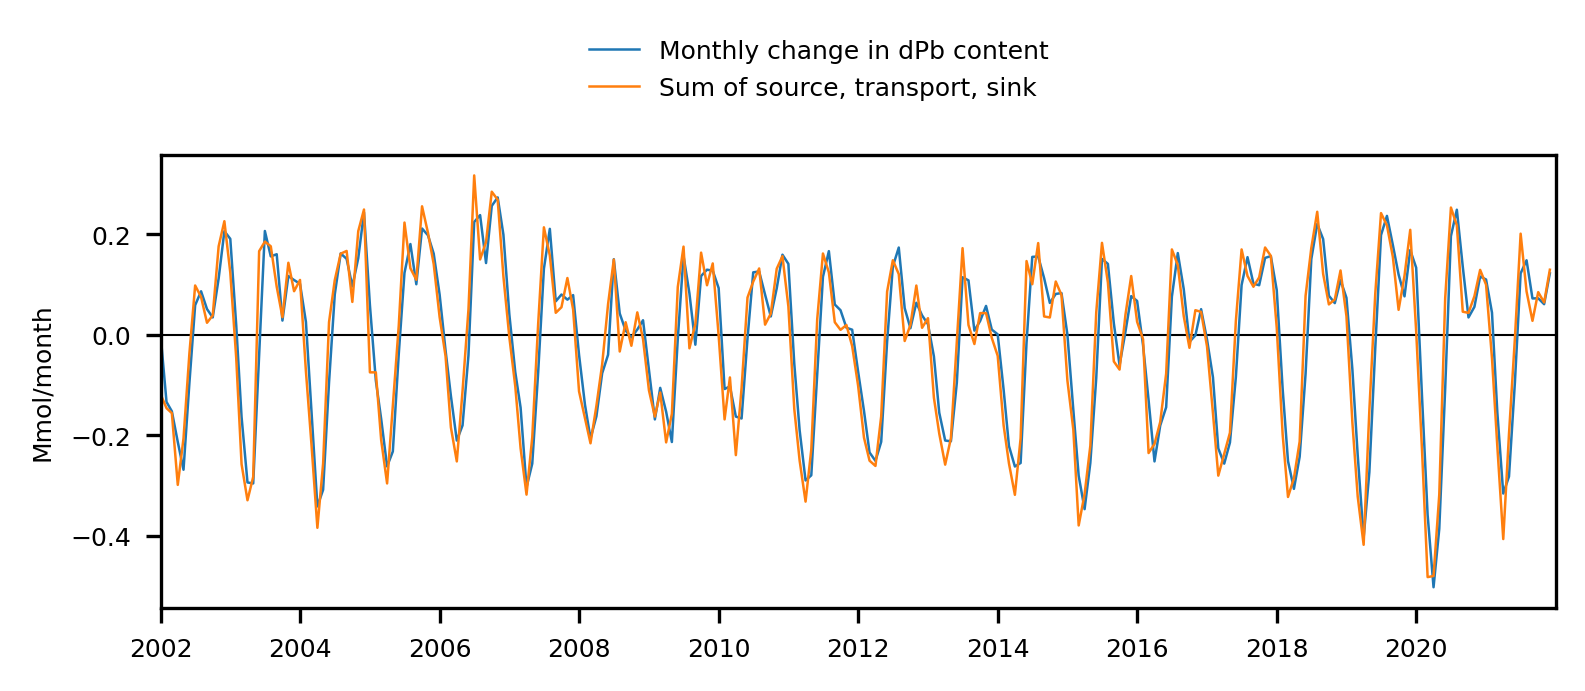

In [31]:
fig, ax = plt.subplots(1,1,figsize=(6,2), dpi=300)

ax.plot([dates[0],plt_years[-1]], [0,0], '-k', linewidth=0.5)

kwags1={'linewidth':0.6, 'linestyle':'-'}

ax.plot(dates, np.diff(dpb_years.flatten(), prepend=dpb_years[0,0])*1e-6, label='Monthly change in dPb content', **kwags1)
ax.plot(dates, (sources + transport_monthly.flatten() - sinks)*1e-6, label='Sum of source, transport, sink', **kwags1)
# ax.plot(dates, (sources + transport_fday.flatten() - sinks)*1e-6, label='Sum of source, transport, sink', **kwags1)

ax.set_xlim(dates[0],plt_years[-1])
ax.set_ylabel('Mmol/month', fontsize=6)

ax.tick_params(axis='both', labelsize=6)

ax.legend(loc=(0.3, 1.1), fontsize=6, frameon=False)

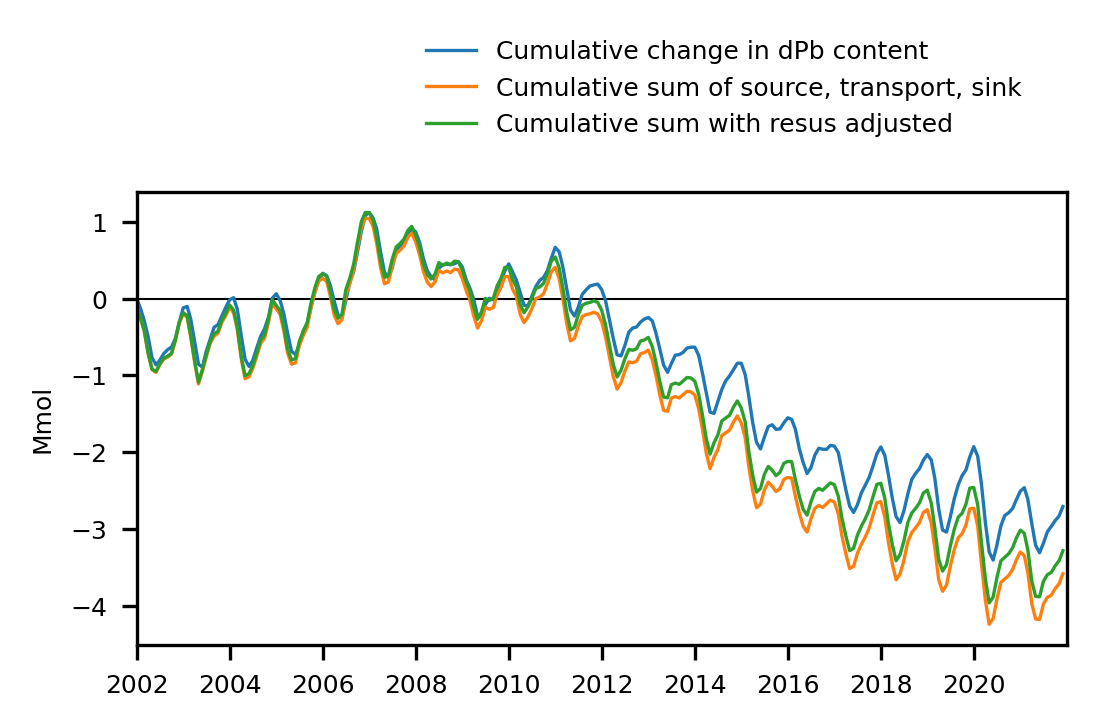

In [32]:
fig, ax = plt.subplots(1,1,figsize=(4,2), dpi=300)

ax.plot([dates[0],plt_years[-1]], [0,0], '-k', linewidth=0.5)

kwags={'linewidth':0.8, 'linestyle':'-'}

ax.plot(dates, np.cumsum(np.diff(dpb_years.flatten(), prepend=dpb_years[0,0]))*1e-6, label='Cumulative change in dPb content', **kwags)
# ax.plot(dates[1:][::-1], np.cumsum((sources[1:]+ transport_monthly.flatten()[1:] - sinks[1:])[::-1])*1e-6, \
#         label='Cumulative sum of source, transport, sink', **kwags)

ax.plot(dates, np.cumsum((sources + transport_monthly.flatten() - sinks))*1e-6, \
        label='Cumulative sum of source, transport, sink', **kwags)

ax.plot(dates, np.cumsum((sources - timeseries_total['resus'] + 66372*np.ones(timeseries_total['resus'].shape) + \
                          transport_monthly.flatten() - sinks))*1e-6, \
        label='Cumulative sum with resus adjusted', **kwags)

ax.set_xlim(dates[0],plt_years[-1])
# ax.set_xlim(dates[0],dates[50])
ax.set_ylabel('Mmol', fontsize=6)

ax.tick_params(axis='both', labelsize=6)

ax.legend(loc=(0.3, 1.1), fontsize=6, frameon=False)

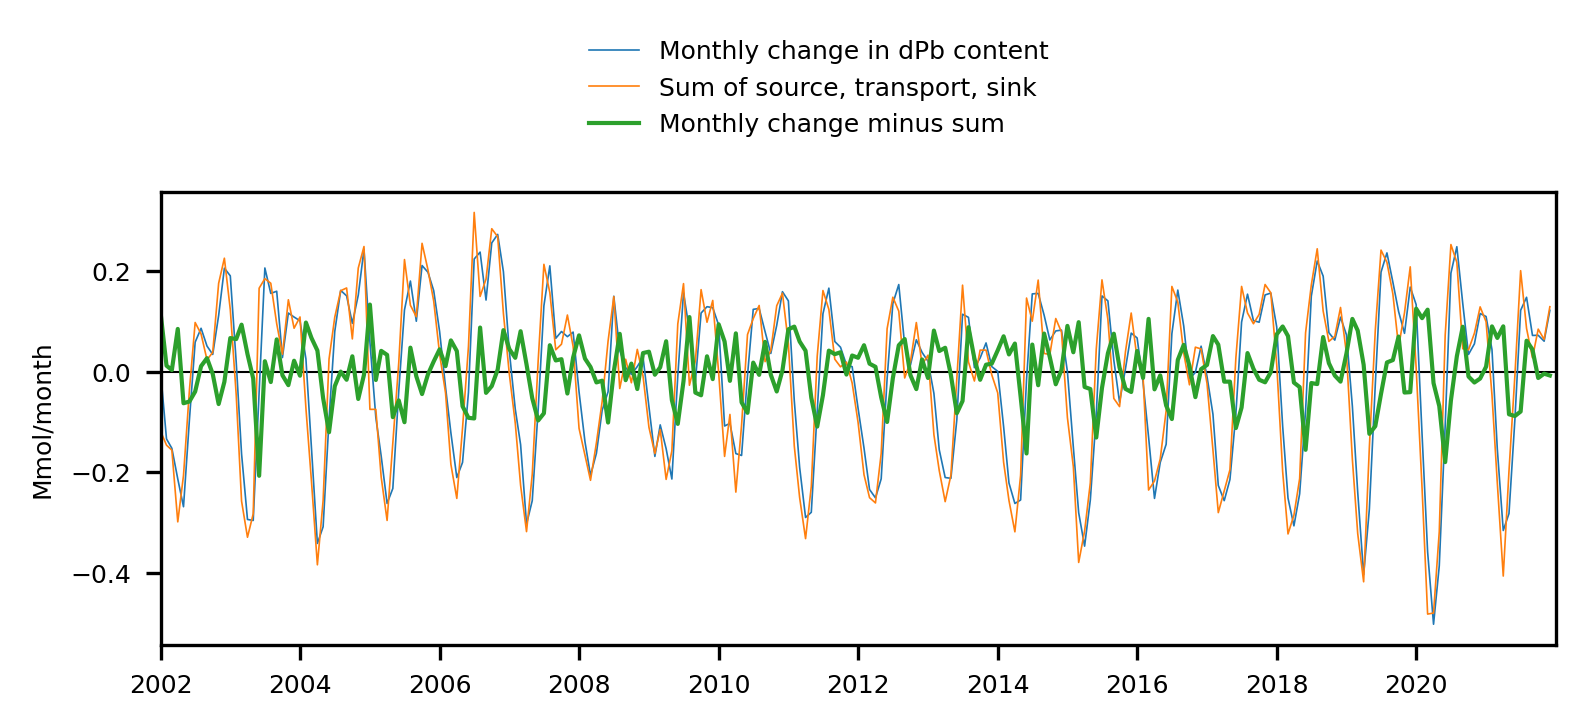

In [65]:
fig, ax = plt.subplots(1,1,figsize=(6,2), dpi=300)

ax.plot([dates[0],plt_years[-1]], [0,0], '-k', linewidth=0.5)

kwags1={'linewidth':1.0, 'linestyle':'-'}
kwags2={'linewidth':0.4, 'linestyle':'-'}

ax.plot(dates, np.diff(dpb_years.flatten(), prepend=dpb_years[0,0])*1e-6, label='Monthly change in dPb content', **kwags2)
ax.plot(dates, (sources + transport_monthly.flatten() - sinks)*1e-6, label='Sum of source, transport, sink', **kwags2)
ax.plot(dates, np.diff(dpb_years.flatten(), prepend=dpb_years[0,0])*1e-6 - \
               (sources + transport_monthly.flatten() - sinks)*1e-6, label='Monthly change minus sum', **kwags1)

ax.set_xlim(dates[0],plt_years[-1])
ax.set_ylabel('Mmol/month', fontsize=6)

ax.tick_params(axis='both', labelsize=6)

ax.legend(loc=(0.3, 1.1), fontsize=6, frameon=False)

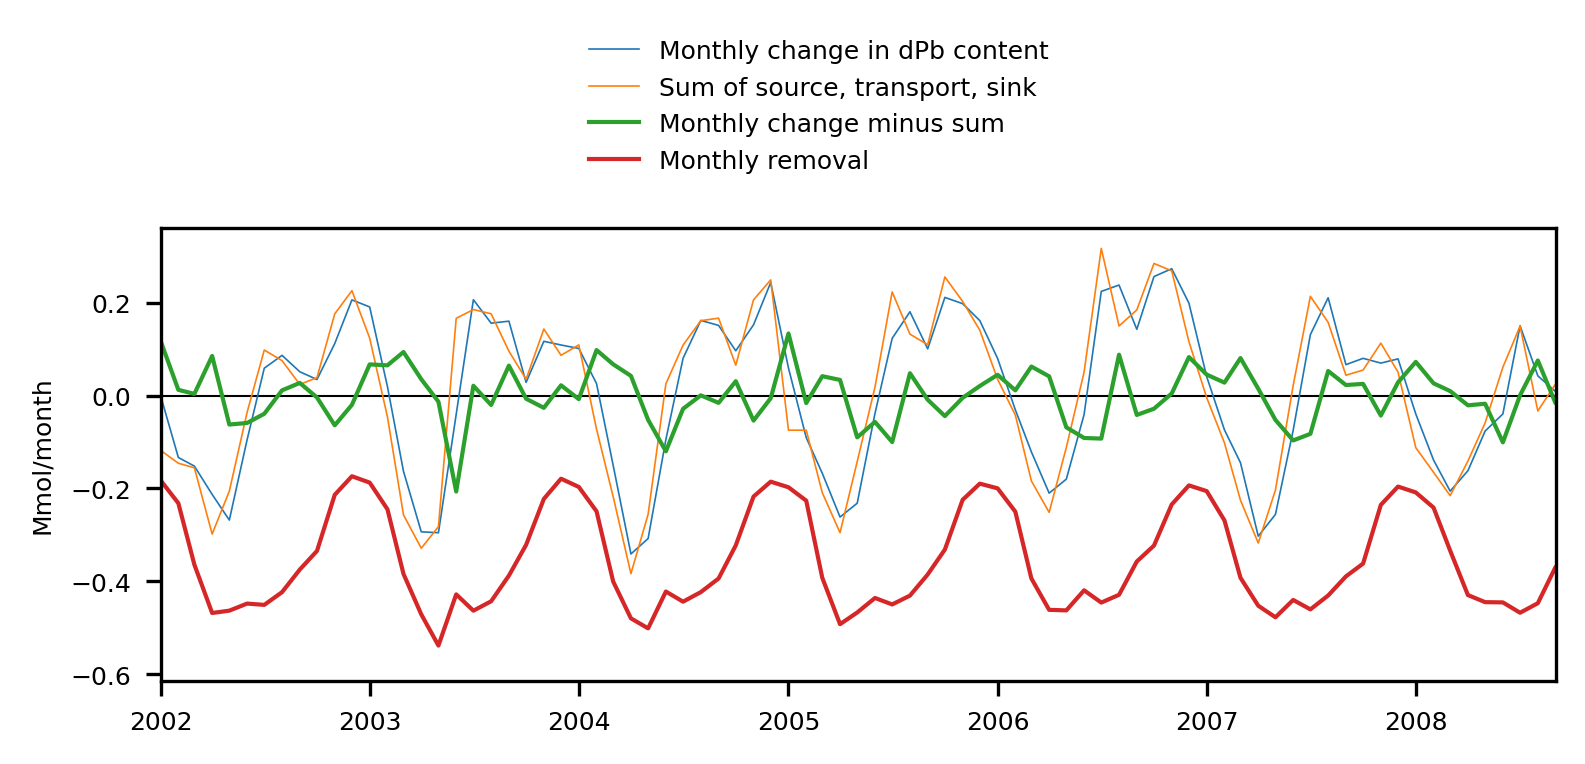

In [146]:
fig, ax = plt.subplots(1,1,figsize=(6,2), dpi=300)

ax.plot([dates[0],plt_years[-1]], [0,0], '-k', linewidth=0.5)

kwags1={'linewidth':1.0, 'linestyle':'-'}
kwags2={'linewidth':0.4, 'linestyle':'-'}

# ax.plot(dates, (sources + transport_fday.flatten() - sinks)*1e-6, label='Sum of source, transport, sink', **kwags1)
ax.plot(dates, np.diff(dpb_years.flatten(), prepend=dpb_years[0,0])*1e-6, label='Monthly change in dPb content', **kwags2)
ax.plot(dates, (sources + transport_monthly.flatten() - sinks)*1e-6, label='Sum of source, transport, sink', **kwags2)
ax.plot(dates, np.diff(dpb_years.flatten(), prepend=dpb_years[0,0])*1e-6 - \
               (sources + transport_monthly.flatten() - sinks)*1e-6, label='Monthly change minus sum', **kwags1)

ax.plot(dates, (-sinks)*1e-6, label='Monthly removal', **kwags1)


ax.set_xlim(dates[0],dates[80])
ax.set_ylabel('Mmol/month', fontsize=6)

ax.tick_params(axis='both', labelsize=6)

ax.legend(loc=(0.3, 1.1), fontsize=6, frameon=False)

In [50]:
monthly_dev = np.diff(dpb_years.flatten(), prepend=dpb_years[0,0])*1e-6 - \
                (sources + transport_monthly.flatten() - sinks)*1e-6

In [55]:
months = np.tile(np.arange(1,13), 20)

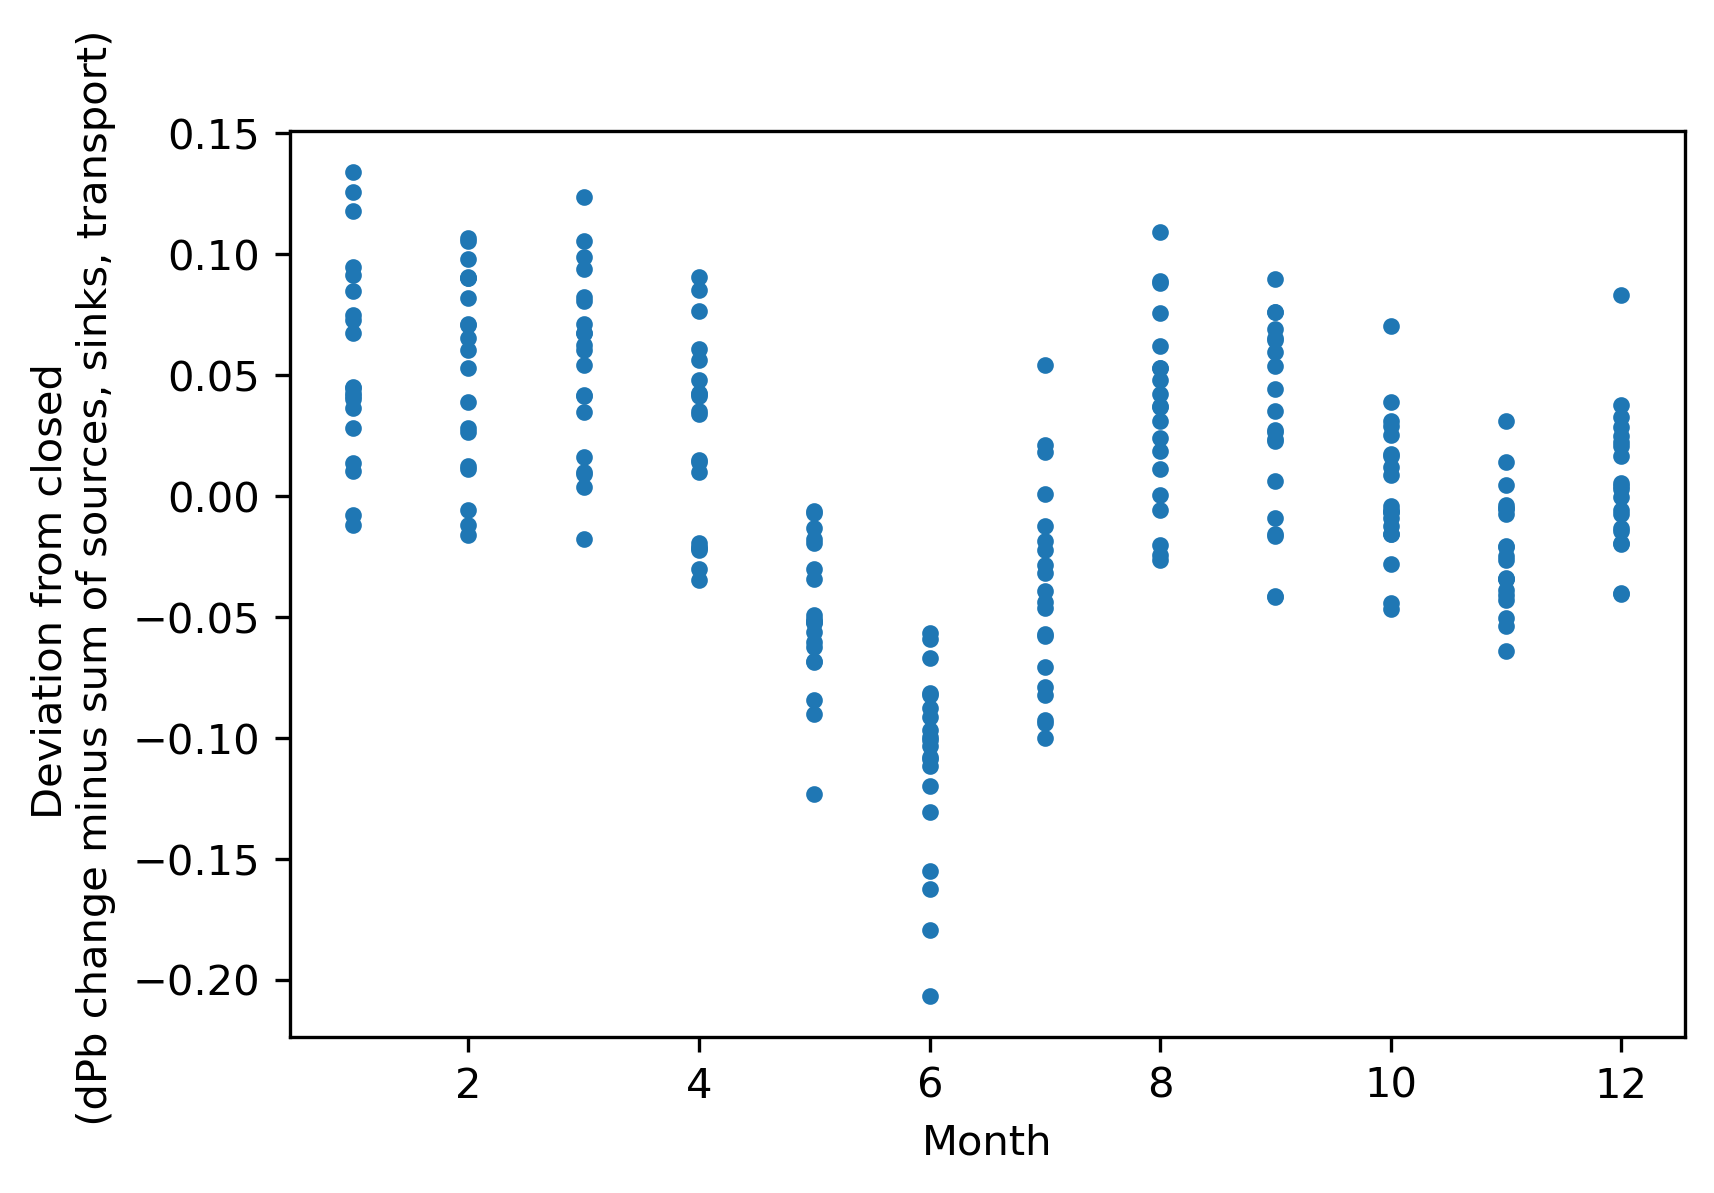

In [67]:
monthly_dev = np.diff(dpb_years.flatten(), prepend=dpb_years[0,0])*1e-6 - \
                (sources + transport_monthly.flatten() - sinks)*1e-6

months = np.tile(np.arange(1,13), 20)

fig, ax = plt.subplots(1,1, figsize=(6,4), dpi=300)
ax.set_xlabel('Month')
ax.set_ylabel('Deviation from closed \n (dPb change minus sum of sources, sinks, transport)')

ax.plot(months, monthly_dev, '.')

To do:
- look at correlation of transport etc. with difference between monthly sums
- offset definitely looks like it's seasonal (missing a source in winter/spring, missing a sink in summer)
- plot labrador sea transport alongside anomaly

In [68]:
# deviation:
dev = np.diff(dpb_years.flatten(), prepend=dpb_years[0,0])*1e-6 - (sources + transport_monthly.flatten() - sinks)*1e-6

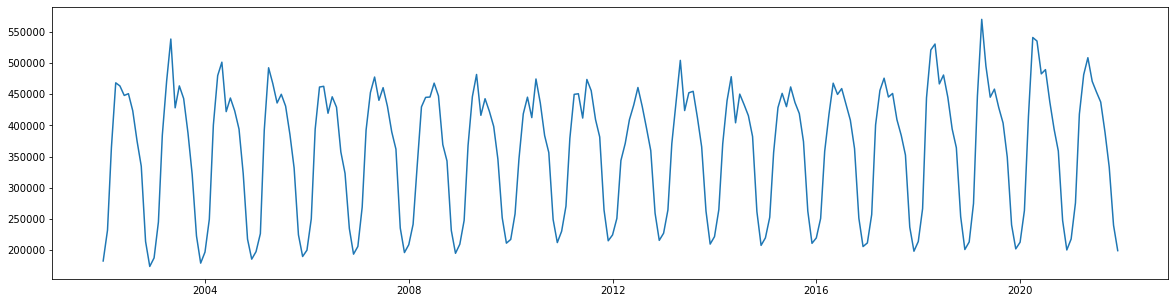

In [34]:
fig, ax = plt.subplots(1,1, figsize=(20,5))
ax.plot(dates, timeseries_total['adsorp'])

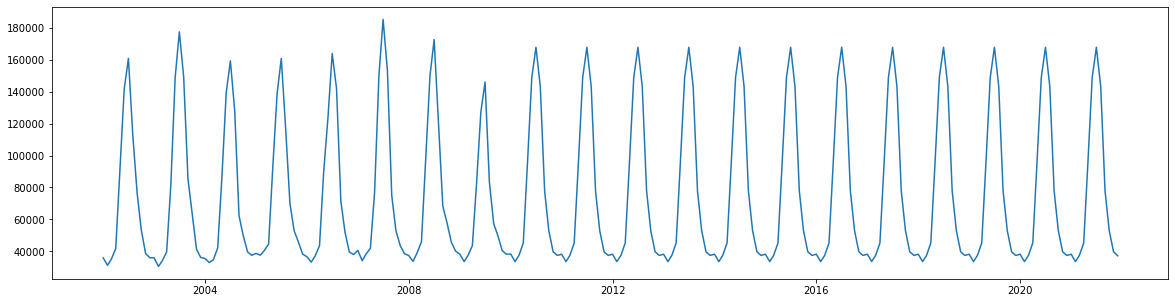

In [89]:
fig, ax = plt.subplots(1,1, figsize=(20,5))
ax.plot(dates, timeseries_total['part_runoff'])

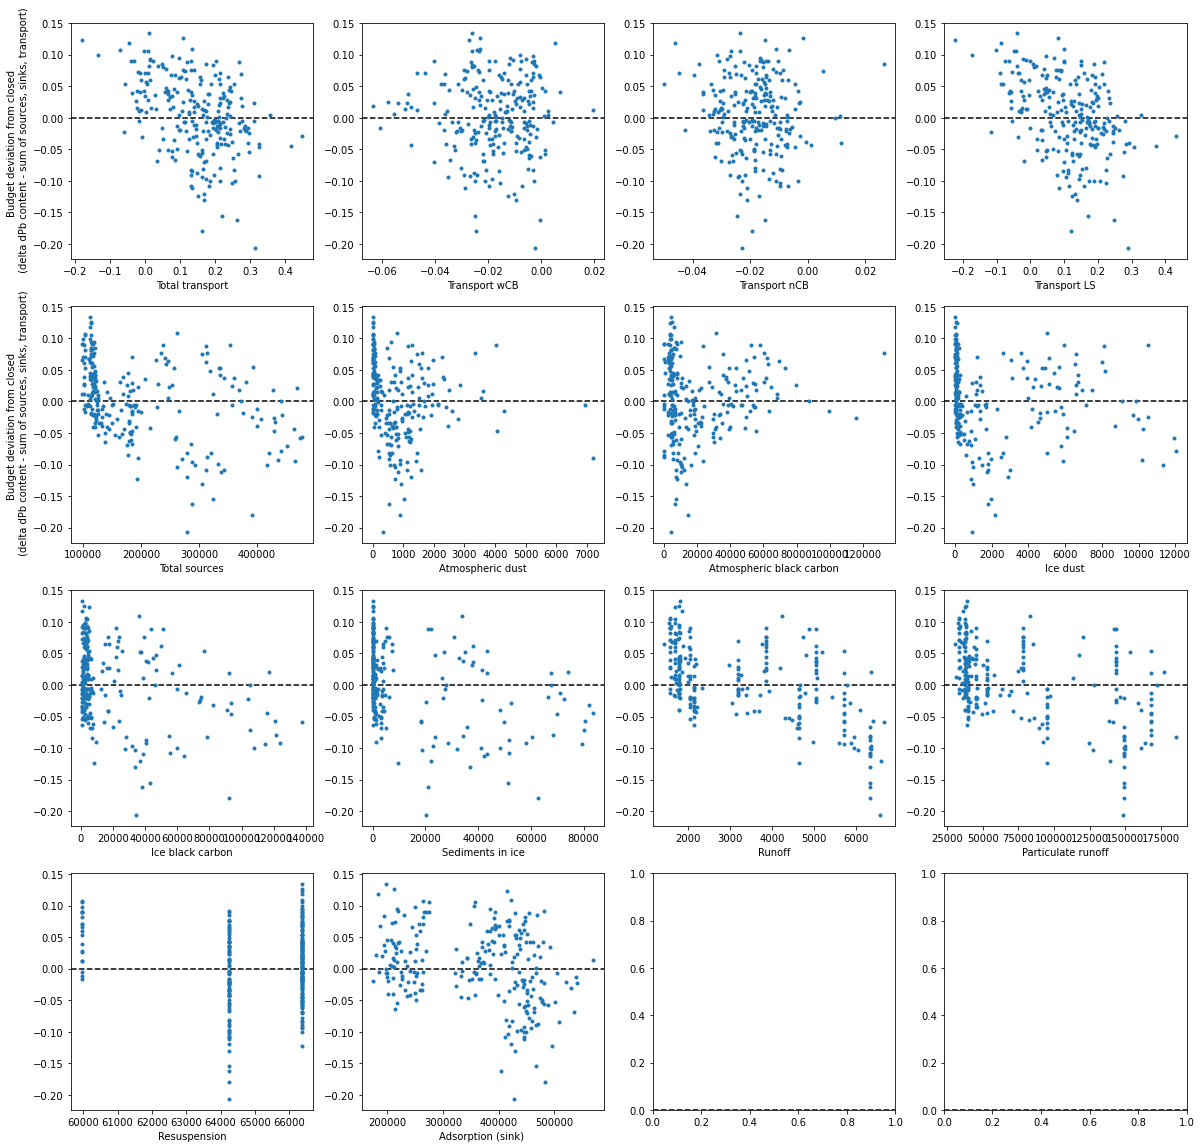

In [69]:
fig, ax = plt.subplots(4,4, figsize=(20,20))
for axis in ax.ravel():
    axis.axhline(y=0, c='k', linestyle='--')

ax[0,0].set_ylabel('Budget deviation from closed \n (delta dPb content - sum of sources, sinks, transport)')
ax[1,0].set_ylabel('Budget deviation from closed \n (delta dPb content - sum of sources, sinks, transport)')

ax[0,0].set_xlabel('Total transport')
ax[0,0].plot(transport_monthly.flatten()*1e-6, dev, '.')
ax[0,1].set_xlabel('Transport wCB')
ax[0,1].plot(transport_monthly_wCB.flatten()*1e-6, dev, '.')
ax[0,2].set_xlabel('Transport nCB')
ax[0,2].plot(transport_monthly_nCB.flatten()*1e-6, dev, '.')
ax[0,3].set_xlabel('Transport LS')
ax[0,3].plot(transport_monthly_LS.flatten()*1e-6, dev, '.')

ax[1,0].set_xlabel('Total sources')
ax[1,0].plot(sources, dev, '.')
ax[1,1].set_xlabel('Atmospheric dust')
ax[1,1].plot(timeseries_total['atm_dust'], dev, '.')
ax[1,2].set_xlabel('Atmospheric black carbon')
ax[1,2].plot(timeseries_total['atm_bc'], dev, '.')
ax[1,3].set_xlabel('Ice dust')
ax[1,3].plot(timeseries_total['ice_dust'], dev, '.')

ax[2,0].set_xlabel('Ice black carbon')
ax[2,0].plot(timeseries_total['ice_bc'], dev, '.')
ax[2,1].set_xlabel('Sediments in ice')
ax[2,1].plot(timeseries_total['sed_ice'], dev, '.')
ax[2,2].set_xlabel('Runoff')
ax[2,2].plot(timeseries_total['runoff'], dev, '.')
ax[2,3].set_xlabel('Particulate runoff')
ax[2,3].plot(timeseries_total['part_runoff'], dev, '.') 

ax[3,0].set_xlabel('Resuspension')
ax[3,0].plot(timeseries_total['resus'], dev, '.')
ax[3,1].set_xlabel('Adsorption (sink) ')
ax[3,1].plot(timeseries_total['adsorp'], dev, '.')

In [70]:
# deviation:
dev = np.diff(dpb_years.flatten())*1e-6 - (sources[0:-1] + transport_monthly.flatten()[0:-1] - sinks[0:-1])*1e-6

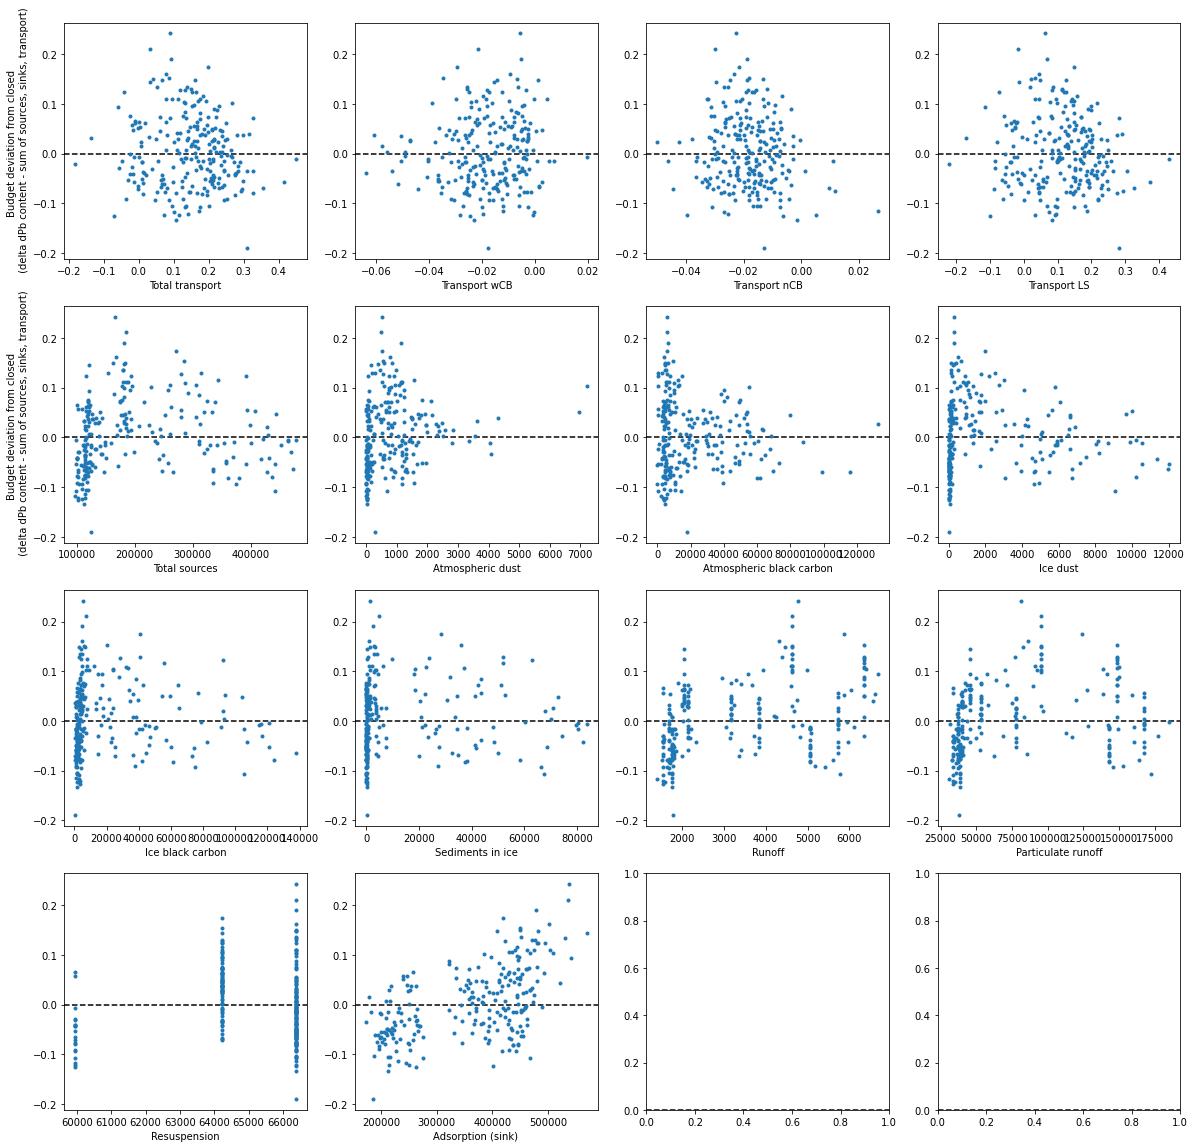

In [71]:
fig, ax = plt.subplots(4,4, figsize=(20,20))
for axis in ax.ravel():
    axis.axhline(y=0, c='k', linestyle='--')

ax[0,0].set_ylabel('Budget deviation from closed \n (delta dPb content - sum of sources, sinks, transport)')
ax[1,0].set_ylabel('Budget deviation from closed \n (delta dPb content - sum of sources, sinks, transport)')

ax[0,0].set_xlabel('Total transport')
ax[0,0].plot(transport_monthly.flatten()[0:-1]*1e-6, dev, '.')
ax[0,1].set_xlabel('Transport wCB')
ax[0,1].plot(transport_monthly_wCB.flatten()[0:-1]*1e-6, dev, '.')
ax[0,2].set_xlabel('Transport nCB')
ax[0,2].plot(transport_monthly_nCB.flatten()[0:-1]*1e-6, dev, '.')
ax[0,3].set_xlabel('Transport LS')
ax[0,3].plot(transport_monthly_LS.flatten()[0:-1]*1e-6, dev, '.')

ax[1,0].set_xlabel('Total sources')
ax[1,0].plot(sources[0:-1], dev, '.')
ax[1,1].set_xlabel('Atmospheric dust')
ax[1,1].plot(timeseries_total['atm_dust'][0:-1], dev, '.')
ax[1,2].set_xlabel('Atmospheric black carbon')
ax[1,2].plot(timeseries_total['atm_bc'][0:-1], dev, '.')
ax[1,3].set_xlabel('Ice dust')
ax[1,3].plot(timeseries_total['ice_dust'][0:-1], dev, '.')

ax[2,0].set_xlabel('Ice black carbon')
ax[2,0].plot(timeseries_total['ice_bc'][0:-1], dev, '.')
ax[2,1].set_xlabel('Sediments in ice')
ax[2,1].plot(timeseries_total['sed_ice'][0:-1], dev, '.')
ax[2,2].set_xlabel('Runoff')
ax[2,2].plot(timeseries_total['runoff'][0:-1], dev, '.')
ax[2,3].set_xlabel('Particulate runoff')
ax[2,3].plot(timeseries_total['part_runoff'][0:-1], dev, '.') 

ax[3,0].set_xlabel('Resuspension')
ax[3,0].plot(timeseries_total['resus'][0:-1], dev, '.')
ax[3,1].set_xlabel('Adsorption (sink) ')
ax[3,1].plot(timeseries_total['adsorp'][0:-1], dev, '.')

In [86]:
# transport monthly wCB follows a similar seasonal cycle

In [124]:
monthly_sedice  = np.zeros((12)); monthly_runoff = np.zeros((12)); 
monthly_prunoff = np.zeros((12)); monthly_atmdust = np.zeros((12)); 
monthly_atmbc   = np.zeros((12)); monthly_icedust = np.zeros((12));
monthly_icebc   = np.zeros((12));
for month in range(1,13):
    monthly_sedice[month-1]  = timeseries_total['sed_ice'][months==month].mean()
    monthly_runoff[month-1]  = timeseries_total['runoff'][months==month].mean()
    monthly_prunoff[month-1] = timeseries_total['part_runoff'][months==month].mean()
    monthly_atmdust[month-1] = timeseries_total['atm_dust'][months==month].mean()
    monthly_atmbc[month-1]   = timeseries_total['atm_bc'][months==month].mean()
    monthly_icedust[month-1] = timeseries_total['ice_dust'][months==month].mean()
    monthly_icebc[month-1]   = timeseries_total['ice_bc'][months==month].mean()

No handles with labels found to put in legend.


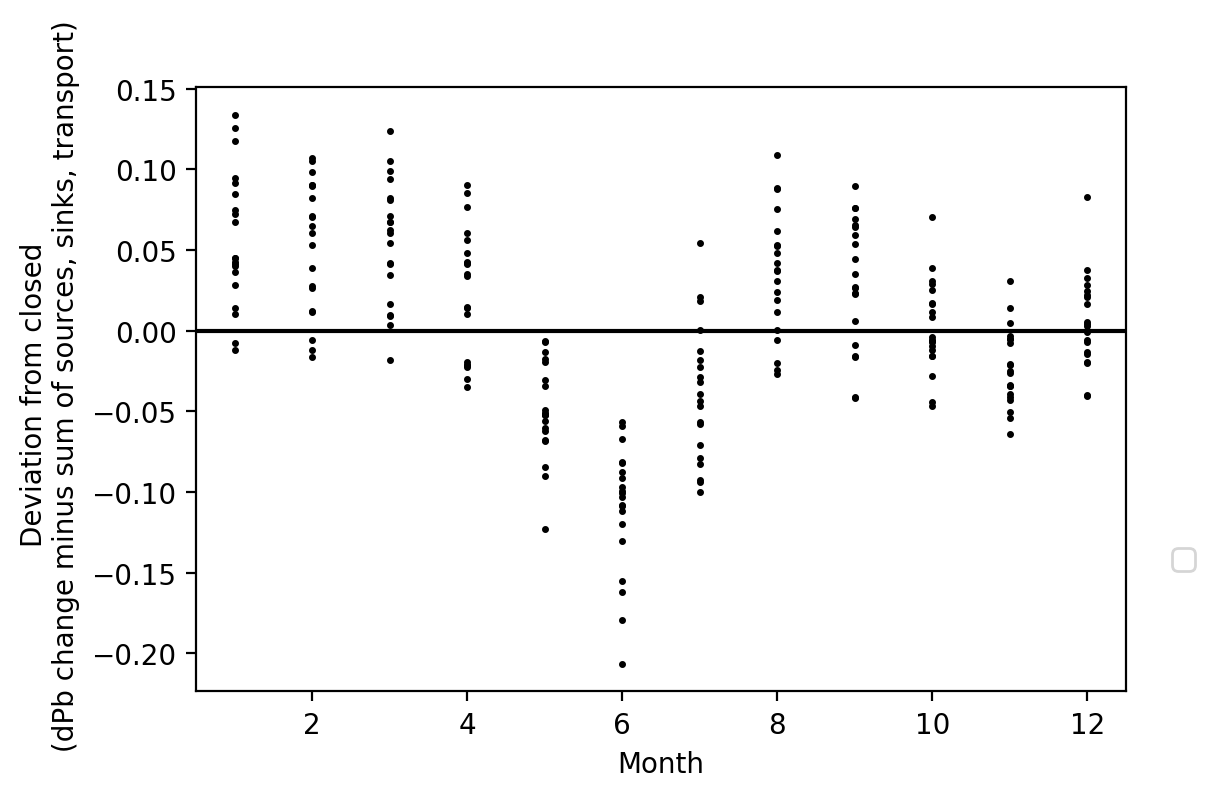

In [142]:
monthly_dev = np.diff(dpb_years.flatten(), prepend=dpb_years[0,0])*1e-6 - \
                (sources + transport_monthly.flatten() - sinks)*1e-6

months = np.tile(np.arange(1,13), 20)

fig, ax = plt.subplots(1,1, figsize=(6,4), dpi=200)
ax.plot([0,13],[0,0], '-k')
ax.set_xlim(0.5,12.5)
ax.set_xlabel('Month')
ax.set_ylabel('Deviation from closed \n (dPb change minus sum of sources, sinks, transport)')
ax.plot(months, monthly_dev, '.k', markersize=3)
ax.legend(loc=(1.05, 0.2))

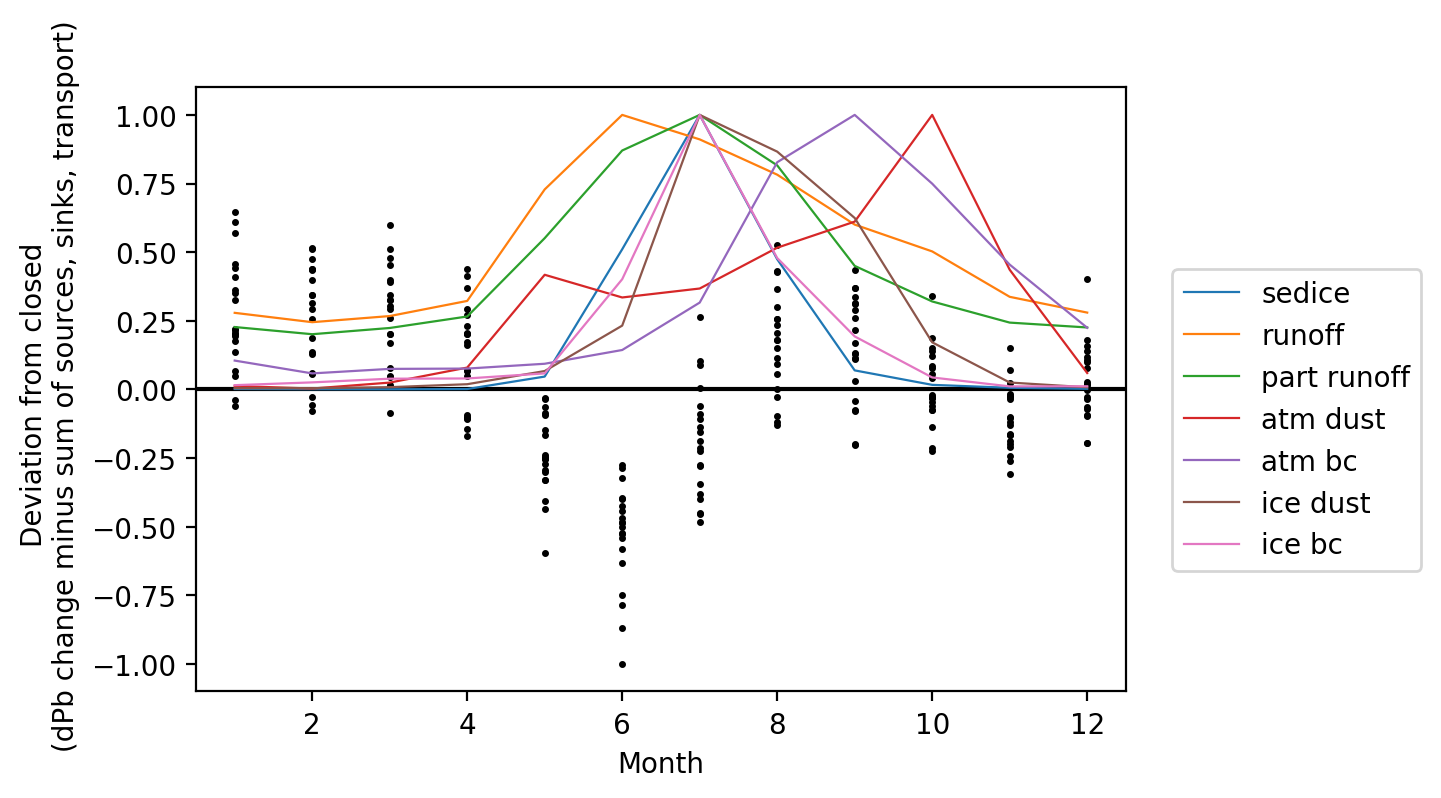

In [133]:
monthly_dev = np.diff(dpb_years.flatten(), prepend=dpb_years[0,0])*1e-6 - \
                (sources + transport_monthly.flatten() - sinks)*1e-6

months = np.tile(np.arange(1,13), 20)

fig, ax = plt.subplots(1,1, figsize=(6,4), dpi=200)
ax.plot([0,13],[0,0], '-k')
ax.set_xlim(0.5,12.5)
ax.set_xlabel('Month')
ax.set_ylabel('Deviation from closed \n (dPb change minus sum of sources, sinks, transport)')
ax.plot(months, monthly_dev/np.amax(np.abs(monthly_dev)), '.k', markersize=3)
ax.plot(np.arange(1,13), monthly_sedice/np.amax(monthly_sedice), '-', label='sedice', linewidth=0.8)
ax.plot(np.arange(1,13), monthly_runoff/np.amax(monthly_runoff), '-', label='runoff', linewidth=0.8)
ax.plot(np.arange(1,13), monthly_prunoff/np.amax(monthly_prunoff), '-', label='part runoff', linewidth=0.8)
ax.plot(np.arange(1,13), monthly_atmdust/np.amax(monthly_atmdust), '-', label='atm dust', linewidth=0.8)
ax.plot(np.arange(1,13), monthly_atmbc/np.amax(monthly_atmbc), '-', label='atm bc', linewidth=0.8)
ax.plot(np.arange(1,13), monthly_icedust/np.amax(monthly_icedust), '-', label='ice dust', linewidth=0.8)
ax.plot(np.arange(1,13), monthly_icebc/np.amax(monthly_icebc), '-', label='ice bc', linewidth=0.8)
ax.legend(loc=(1.05, 0.2))

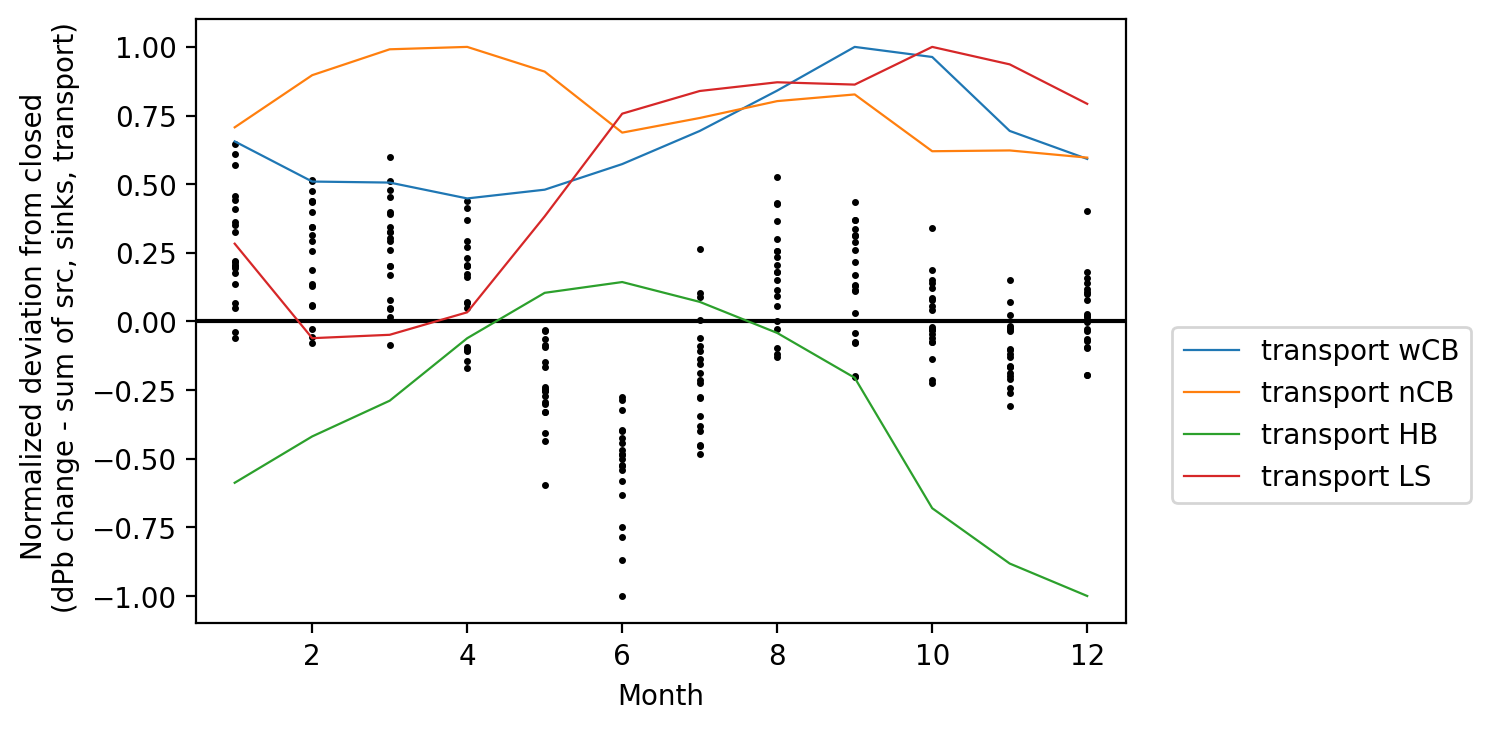

In [144]:
monthly_dev = np.diff(dpb_years.flatten(), prepend=dpb_years[0,0])*1e-6 - \
                (sources + transport_monthly.flatten() - sinks)*1e-6

months = np.tile(np.arange(1,13), 20)

fig, ax = plt.subplots(1,1, figsize=(6,4), dpi=200)
ax.plot([0,13],[0,0], '-k')
ax.set_xlim(0.5,12.5)
ax.set_xlabel('Month')
ax.set_ylabel('Normalized deviation from closed \n (dPb change - sum of src, sinks, transport)')
ax.plot(months, monthly_dev/np.amax(np.abs(monthly_dev)), '.k', markersize=3)
ax.plot(np.arange(1,13), -1*transport_monthly_wCB.mean(axis=0)/np.amax(np.abs(transport_monthly_wCB.mean(axis=0))),'-', label='transport wCB', linewidth=0.8)
ax.plot(np.arange(1,13), -1*transport_monthly_nCB.mean(axis=0)/np.amax(np.abs(transport_monthly_nCB.mean(axis=0))),'-', label='transport nCB', linewidth=0.8)
ax.plot(np.arange(1,13), transport_monthly_HB.mean(axis=0)/np.amax(np.abs(transport_monthly_HB.mean(axis=0))),'-', label='transport HB', linewidth=0.8)
ax.plot(np.arange(1,13), transport_monthly_LS.mean(axis=0)/np.amax(np.abs(transport_monthly_LS.mean(axis=0))),'-', label='transport LS', linewidth=0.8)
ax.legend(loc=(1.05,0.2))

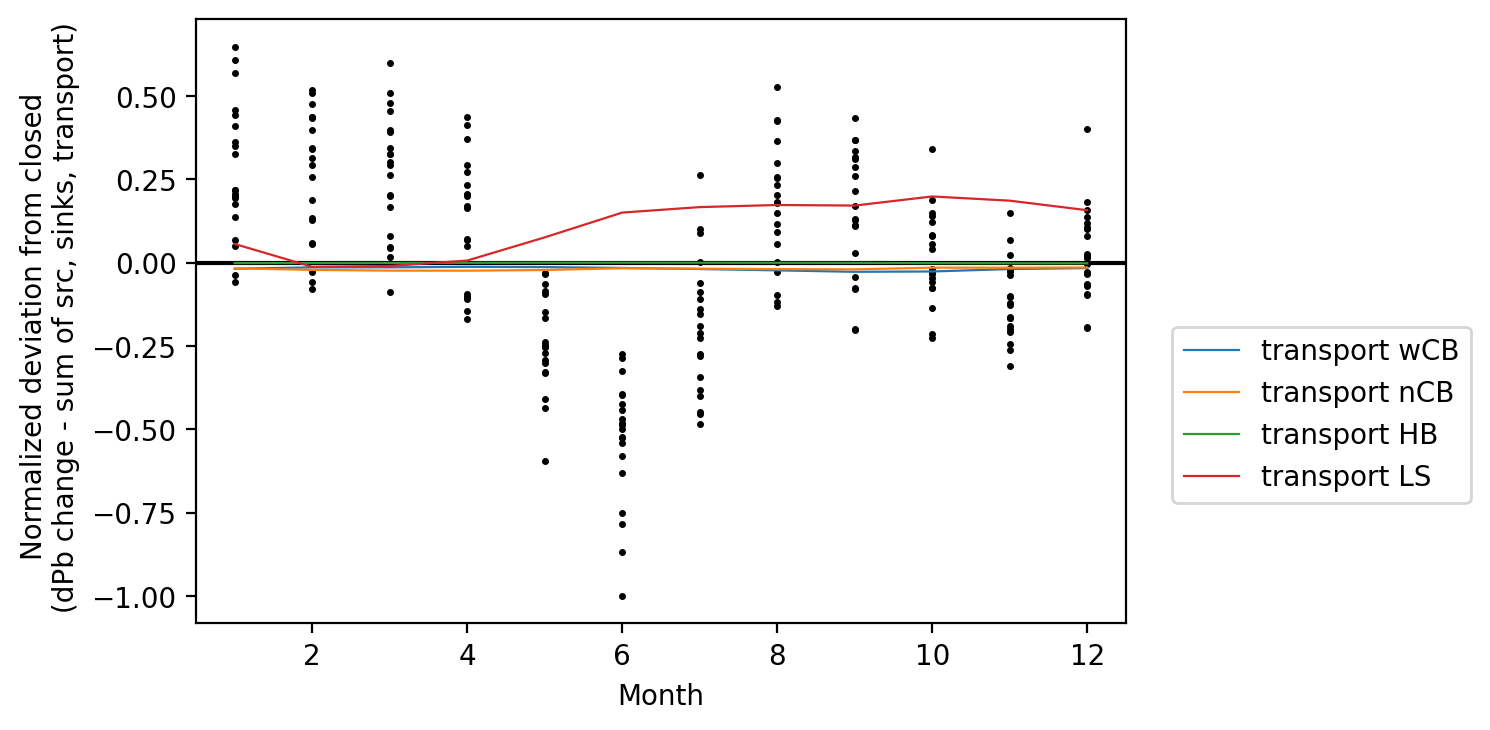

In [143]:
monthly_dev = np.diff(dpb_years.flatten(), prepend=dpb_years[0,0])*1e-6 - \
                (sources + transport_monthly.flatten() - sinks)*1e-6

months = np.tile(np.arange(1,13), 20)

fig, ax = plt.subplots(1,1, figsize=(6,4), dpi=200)
ax.plot([0,13],[0,0], '-k')
ax.set_xlim(0.5,12.5)
ax.set_xlabel('Month')
ax.set_ylabel('Deviation from closed \n (dPb change - sum of src, sinks, transport)')
ax.plot(months, monthly_dev/np.amax(np.abs(monthly_dev)), '.k', markersize=3)
ax.plot(np.arange(1,13), transport_monthly_wCB.mean(axis=0)*1e-6,'-', label='transport wCB', linewidth=0.8)
ax.plot(np.arange(1,13), transport_monthly_nCB.mean(axis=0)*1e-6,'-', label='transport nCB', linewidth=0.8)
ax.plot(np.arange(1,13), transport_monthly_HB.mean(axis=0)*1e-6,'-', label='transport HB', linewidth=0.8)
ax.plot(np.arange(1,13), transport_monthly_LS.mean(axis=0)*1e-6,'-', label='transport LS', linewidth=0.8)
ax.legend(loc=(1.05,0.2))

No handles with labels found to put in legend.


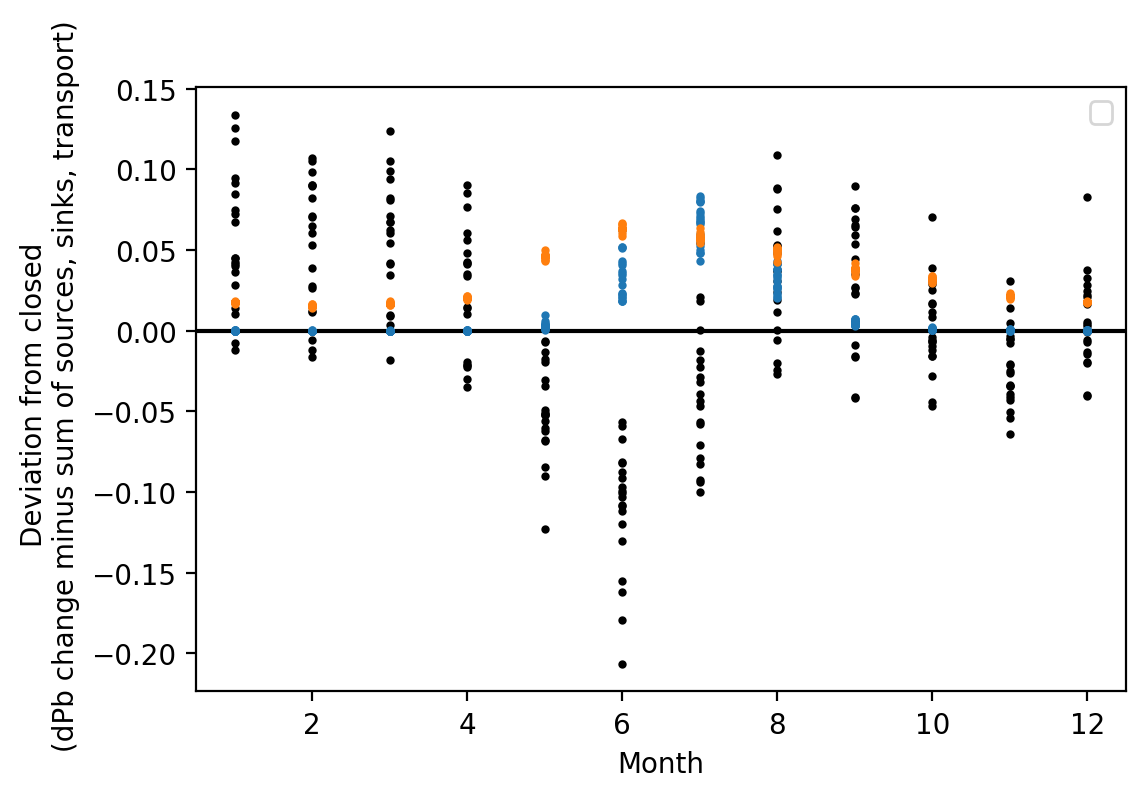

In [115]:
monthly_dev = np.diff(dpb_years.flatten(), prepend=dpb_years[0,0])*1e-6 - \
                (sources + transport_monthly.flatten() - sinks)*1e-6

months = np.tile(np.arange(1,13), 20)

fig, ax = plt.subplots(1,1, figsize=(6,4), dpi=200)
ax.plot([0,13],[0,0], '-k')
ax.set_xlim(0.5,12.5)
ax.set_xlabel('Month')
ax.set_ylabel('Deviation from closed \n (dPb change minus sum of sources, sinks, transport)')

# ax.plot(transport_months+0.1, transport_monthly_wCB.flatten()*1e-6, '.', markersize=4, label='wCB')
# ax.plot(transport_months+0.2, transport_monthly_nCB.flatten()*1e-6, '.', markersize=4, label='nCB')
# ax.plot(transport_months+0.3, transport_monthly_LS.flatten()*1e-6, '.', markersize=4, label='LS')
ax.plot(months, monthly_dev, '.k', markersize=4)
# ax.plot(months, timeseries_total['atm_dust']*1e-4, '.', markersize=4)
# ax.plot(months, timeseries_total['atm_bc']*1e-6, '.', markersize=4)
# ax.plot(months, timeseries_total['ice_dust']*1e-5, '.', markersize=4)
# ax.plot(months, timeseries_total['ice_bc']*1e-6, '.', markersize=4)
ax.plot(months, timeseries_total['sed_ice']*1e-6, '.', markersize=4)
ax.plot(months, timeseries_total['runoff']*1e-5, '.', markersize=4)
ax.legend()

In [ ]:
# make a scatter plot of each component versus the other by month rather than month/year

In [74]:
transport_months = np.repeat(np.arange(1,13), 20)
# transport_monthly.flatten()

In [ ]:
fig, ax = plt.subplots(4,4, figsize=(20,20))
for axis in ax.ravel():
    axis.axhline(y=0, c='k', linestyle='--')

ax[0,0].set_ylabel('Budget deviation from closed \n (delta dPb content - sum of sources, sinks, transport)')
ax[1,0].set_ylabel('Budget deviation from closed \n (delta dPb content - sum of sources, sinks, transport)')

ax[0,0].set_xlabel('Total transport')
ax[0,0].plot(transport_monthly.flatten()[0:-1]*1e-6, dev, '.')
ax[0,1].set_xlabel('Transport wCB')
ax[0,1].plot(transport_monthly_wCB.flatten()[0:-1]*1e-6, dev, '.')
ax[0,2].set_xlabel('Transport nCB')
ax[0,2].plot(transport_monthly_nCB.flatten()[0:-1]*1e-6, dev, '.')
ax[0,3].set_xlabel('Transport LS')
ax[0,3].plot(transport_monthly_LS.flatten()[0:-1]*1e-6, dev, '.')

ax[1,0].set_xlabel('Total sources')
ax[1,0].plot(sources[0:-1], dev, '.')
ax[1,1].set_xlabel('Atmospheric dust')
ax[1,1].plot(timeseries_total['atm_dust'][0:-1], dev, '.')
ax[1,2].set_xlabel('Atmospheric black carbon')
ax[1,2].plot(timeseries_total['atm_bc'][0:-1], dev, '.')
ax[1,3].set_xlabel('Ice dust')
ax[1,3].plot(timeseries_total['ice_dust'][0:-1], dev, '.')

ax[2,0].set_xlabel('Ice black carbon')
ax[2,0].plot(timeseries_total['ice_bc'][0:-1], dev, '.')
ax[2,1].set_xlabel('Sediments in ice')
ax[2,1].plot(timeseries_total['sed_ice'][0:-1], dev, '.')
ax[2,2].set_xlabel('Runoff')
ax[2,2].plot(timeseries_total['runoff'][0:-1], dev, '.')
ax[2,3].set_xlabel('Particulate runoff')
,
ax[2,3].plot(timeseries_total['part_runoff'][0:-1], dev, '.') 

ax[3,0].set_xlabel('Resuspension')
ax[3,0].plot(timeseries_total['resus'][0:-1], dev, '.')
ax[3,1].set_xlabel('Adsorption (sink) ')
ax[3,1].plot(timeseries_total['adsorp'][0:-1], dev, '.')